# Projet IA - 4BiM - 2021

#### Auteurs : Aurélie Fischer et Nicolas Mendiboure 
#### Enseignants : Sergio Peignier et Chistophe Rigotti 


In [4]:
%matplotlib inline 

In [5]:
import scipy
import numpy
import math
import sklearn
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

#import sergio_peignier as sp
#import chistophe_rigotti as cr

# 1. Lecture des données:

Au départ, nous avons construit un jeu de données à partir du site http://databank.worldbank.org . Celui-ci contient diverses informations sur les pays du monde entier. Au total, nous avons alors 217 pays pour lesquels nous avons sélectionné 50 variables différentes, qui vont nous permettre de les caractériser. 

In [6]:
sparse_df = pds.read_csv("./datas/Data-IA-World-Development-Indicator.txt", sep="\t", header=0)

In [7]:
sparse_df.shape

(217, 50)

In [8]:
#sparse_df.head()
#sparse_df.tail()

In [9]:
# Quelques statistiques :
sparse_df.describe() 

,Time,Access to clean fuels and technologies for cooking (% of population) [EG.CFT.ACCS.ZS],Access to electricity (% of population) [EG.ELC.ACCS.ZS],Adolescents out of school (% of lower secondary school age) [SE.SEC.UNER.LO.ZS],Adults (ages 15-49) newly infected with HIV [SH.HIV.INCD],Age dependency ratio (% of working-age population) [SP.POP.DPND],"Air transport, passengers carried [IS.AIR.PSGR]","Air transport, freight (million ton-km) [IS.AIR.GOOD.MT.K1]",Alternative and nuclear energy (% of total energy use) [EG.USE.COMM.CL.ZS],Aquaculture production (metric tons) [ER.FSH.AQUA.MT],...,Net domestic credit (current LCU) [FM.AST.DOMS.CN],Number of infant deaths [SH.DTH.IMRT],Number of maternal deaths [SH.MMR.DTHS],Number of neonatal deaths [SH.DTH.NMRT],"Physicians (per 1,000 people) [SH.MED.PHYS.ZS]","Population ages 0-14, total [SP.POP.0014.TO]","Population ages 15-64, total [SP.POP.1564.TO]","Population ages 65 and above, total [SP.POP.65UP.TO]","Preprimary education, duration (years) [SE.PRE.DURS]","Primary education, teachers [SE.PRM.TCHR]"
count,217.0,189.000000,215.000000,109.000000,117.000000,193.000000,1.590000e+02,147.000000,135.000000,1.890000e+02,...,1.790000e+02,193.000000,185.000000,193.000000,115.000000,1.930000e+02,1.930000e+02,1.930000e+02,204.000000,1.440000e+02
mean,2014.0,64.259952,82.801668,10.309815,10353.846154,58.868986,2.029743e+07,1257.354486,7.661192,5.323972e+05,...,1.144075e+14,23213.663212,1693.475676,14277.362694,2.252597,9.883401e+06,2.453930e+07,3.011023e+06,3.794118,1.791546e+05
std,0.0,37.864623,27.415219,13.702380,30059.385299,18.142642,7.119128e+07,4070.076123,10.282093,4.416726e+06,...,7.027220e+14,84052.542373,6121.502147,56366.434377,1.576674,3.392646e+07,9.669803e+07,1.111471e+07,1.568396,6.395749e+05
min,2014.0,0.540000,7.000000,0.014250,100.000000,16.597578,0.000000e+00,0.000000,0.000000,0.000000e+00,...,-2.036686e+13,1.000000,0.000000,0.000000,0.023000,1.983300e+04,5.804700e+04,3.609000e+03,1.000000,4.000000e+01
25%,2014.0,25.500000,72.640266,1.454860,1000.000000,47.419280,4.660800e+05,1.937652,0.745562,2.500000e+02,...,1.781590e+10,257.000000,7.000000,186.000000,0.895900,4.523450e+05,1.281340e+06,9.325300e+04,3.000000,8.496500e+03
50%,2014.0,84.600000,99.657085,4.885500,2000.000000,53.173647,1.756070e+06,30.815530,3.327952,2.871000e+03,...,3.202253e+11,2177.000000,65.000000,1277.000000,2.207000,1.902944e+06,5.165692e+06,4.789610e+05,3.000000,3.847750e+04
75%,2014.0,98.160000,100.000000,12.759400,5700.000000,68.765506,1.148247e+07,434.455823,11.195187,3.072566e+04,...,2.812489e+12,15086.000000,1000.000000,8782.000000,3.224450,8.123737e+06,1.562341e+07,1.687922e+06,5.000000,1.065230e+05
max,2014.0,100.000000,100.000000,70.980927,270000.000000,111.862799,7.627100e+08,38225.196089,49.590417,5.880000e+07,...,6.506499e+15,905319.000000,66000.000000,665584.000000,7.567300,3.747590e+08,9.945425e+08,1.223259e+08,7.000000,5.859672e+06


# 2. Création des classes (continents) :

Pour anticiper les analyses que nous allons effectuer sur le jeu de données, nous avions besoin d'établir des classes auxquelles chaque pays que l'on considère est susceptible d'appartenir. Il nous a paru naturel de choisir les continents pour classer chaque pays. Pour cela, on utilise une librairie *pycountry_convert* qui associe un code pays (par exemple "CHN" pour la Chine) à un code continent : 

* AS pour l'Asie
* AF pour l'Afrique
* NA pour l'Amérique du nord
* OC pour l'Océanie
* AN pour l'Antarctique
* EU pour l'Europe
* SA pour l'Amérique du sud

On retient donc qu'on pourrait classer les pays dans 7 classes possibles.

In [10]:
import pycountry_convert as pc

In [11]:
country_code = sparse_df[["Country Name", "Country Code"]]

In [12]:
country_code_np = country_code["Country Code"].values

In [13]:
def country_to_continent(country_code):
    res = []
    for code3 in country_code :
        if (code3 == "CHI"):
            code2 = "GB"
        elif (code3 == "XKX"):
            code2 = "XK"
        else:
            code2 = pc.country_alpha3_to_country_alpha2(code3)
            
        
        if (code2 == "TL"):
            country_continent_code = "AS"
        elif (code2 == "SX"):
            country_continent_code = "SA"
        else:
            country_continent_code = pc.country_alpha2_to_continent_code(code2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        res.append(country_continent_name)
    return res

In [14]:
continents = country_to_continent(country_code_np)

In [15]:
sparse_df["Continents"] = continents

# 3. Selection et filtrage des données :

Avant de pouvoir effectuer un clustering, on réalise une sélection des attributs ainsi que des pays (les objets étudiés ici) de sorte à ce qu'on ait assez d'informations à traiter.

## 3.1 Selection des attributs (colonnes) :

On commence par sélectionner les attributs. Ceux-ci sont choisis de sorte à ce qu'ils aient de l'information pour un maximum de pays possible. Dans l'idéal, on aimerait avoir de l'information pour chaque pays et chaque attribut, mais cela est très rare. Ainsi, nous avons défini une limite de nombre manquant de données (nombre de NaN) par attribut. Si l'attribut a un nombre de données manquantes supérieur à cette limite, alors on le considère plus dans notre étude. Cette limite a été fixée à 40 après plusieurs essais. Elle est suffisamment basse pour garder les colonnes contenant un maximum de données, tout en étant assez haute pour conserver une large gamme d'attributs.

In [16]:
#Fonction qui supprime une colonne (attribut) si le nb de NaN >= limit

def delete_NaN_col(df, limit):
    NaN_col = df.isna().sum()
    tmp = df.copy(deep=True) 
    
    for i in range(df.shape[1]):
        if NaN_col[i] >= limit:
            df = df.drop(columns = tmp.columns[i])
            
    return(df)

In [17]:
sparse_df2 = delete_NaN_col(sparse_df, 40)

In [18]:
# On enlèvre les colonnes 'Time' et 'Time Code' qui ne nous interessent pas ici
def remove_useless_col(df):
    df = df.drop(columns = ["Time", "Time Code", "Country Code"])
    return (df)

In [19]:
sparse_df2 = remove_useless_col(sparse_df2)

In [20]:
#Visualisation du nombre de donnees manquantes par colonne apres selection
sparse_df2.isna().sum()

Country Name                                                                              0
Access to clean fuels and technologies for cooking (% of population) [EG.CFT.ACCS.ZS]    28
Access to electricity (% of population) [EG.ELC.ACCS.ZS]                                  2
Age dependency ratio (% of working-age population) [SP.POP.DPND]                         24
Aquaculture production (metric tons) [ER.FSH.AQUA.MT]                                    28
Birth rate, crude (per 1,000 people) [SP.DYN.CBRT.IN]                                    10
Capture fisheries production (metric tons) [ER.FSH.CAPT.MT]                               1
Cereal production (metric tons) [AG.PRD.CREL.MT]                                         36
Commercial bank branches (per 100,000 adults) [FB.CBK.BRCH.P5]                           37
Compulsory education, duration (years) [SE.COM.DURS]                                     24
Death rate, crude (per 1,000 people) [SP.DYN.CDRT.IN]                           

## 3.2 Selection des objets (lignes) :

En suivant la même logique que pour les attributs, on sélectionne les objets, donc les pays, pour lesquels on a assez d'informations pour les attributs restants. 

Ainsi, on obtient un jeu de données assez complet où on pourra réellement comparer chaque objet en fonction de comment il est caractérisé par les différents attributs.

In [21]:
#Fonction qui supprime une ligne (object) si le nb de NaN >= limit

def delete_NaN_row(df, limit):
    NaN_row = df.isna().sum(axis=1)
    tmp = df.copy(deep=True) #temporary df
    
    for i in range(df.shape[0]):
        if NaN_row[i] >= limit:
            df = df.drop([i], axis = 0)
            
    return(df)

In [22]:
sparse_df3 = delete_NaN_row(sparse_df2, 1)

In [23]:
#On remplace les indexes des ligne {0, 1, 2, ..n} par les noms de pays
#Puis on supprime la colonne "Country Name" pour n'avoir plus que des valeurs numeriques
sparse_df3.index = sparse_df3['Country Name']
sparse_df3 = sparse_df3.drop(columns = ['Country Name'])

In [24]:
#Visualisation du jeu de donnees apres selection des attributs et des objets
sparse_df3.head()

,Access to clean fuels and technologies for cooking (% of population) [EG.CFT.ACCS.ZS],Access to electricity (% of population) [EG.ELC.ACCS.ZS],Age dependency ratio (% of working-age population) [SP.POP.DPND],Aquaculture production (metric tons) [ER.FSH.AQUA.MT],"Birth rate, crude (per 1,000 people) [SP.DYN.CBRT.IN]",Capture fisheries production (metric tons) [ER.FSH.CAPT.MT],Cereal production (metric tons) [AG.PRD.CREL.MT],"Commercial bank branches (per 100,000 adults) [FB.CBK.BRCH.P5]","Compulsory education, duration (years) [SE.COM.DURS]","Death rate, crude (per 1,000 people) [SP.DYN.CDRT.IN]",...,Lifetime risk of maternal death (%) [SH.MMR.RISK.ZS],Net domestic credit (current LCU) [FM.AST.DOMS.CN],Number of infant deaths [SH.DTH.IMRT],Number of maternal deaths [SH.MMR.DTHS],Number of neonatal deaths [SH.DTH.NMRT],"Population ages 0-14, total [SP.POP.0014.TO]","Population ages 15-64, total [SP.POP.1564.TO]","Population ages 65 and above, total [SP.POP.65UP.TO]","Preprimary education, duration (years) [SE.PRE.DURS]",Continents
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,27.99,89.50000,92.649141,1100.000,35.706,1000.0,6748125.0,2.304279,9.0,7.141,...,4.216704,-7.152743e+09,64829.0,9300.0,49416.0,15230627.0,17322057.0,818110.0,1.0,Asia
Albania,73.98,100.00000,45.774680,2424.200,12.259,9052.5,700370.0,22.066921,9.0,7.219,...,0.028416,9.484700e+11,314.0,6.0,210.0,555294.0,1981897.0,351913.0,5.0,Europe
Algeria,93.10,99.84082,51.509189,2410.973,25.538,97828.0,3435535.0,5.210910,10.0,4.709,...,0.369534,3.101592e+12,21477.0,1100.0,15574.0,11001501.0,25690645.0,2231542.0,1.0,Africa
Angola,46.67,32.00000,97.942206,305.000,43.182,442084.0,1823436.0,10.188728,6.0,9.454,...,1.630087,3.015869e+12,69089.0,3000.0,36745.0,12710366.0,13610932.0,620481.0,1.0,Africa
Antigua and Barbuda,98.61,100.00000,44.621346,13.000,16.026,3114.0,73.0,30.824413,11.0,6.188,...,0.082073,2.787475e+09,10.0,1.0,7.0,21190.0,64003.0,7369.0,5.0,North America


## 3.3 Études des correlations :

Après sélection des objets et des attributs selon la quantité d'informations manquantes, on va étudier la corrélation présente au sein des données. Cela permet de se rendre compte de la redondance de l'information qui y est présente. L'objectif est alors d'éviter cette redondance en ne considérant uniquement des attributs faiblement corrélés. 

In [25]:
#Mesure de la correlation de nos donnees
corr_df = sparse_df3.corr()

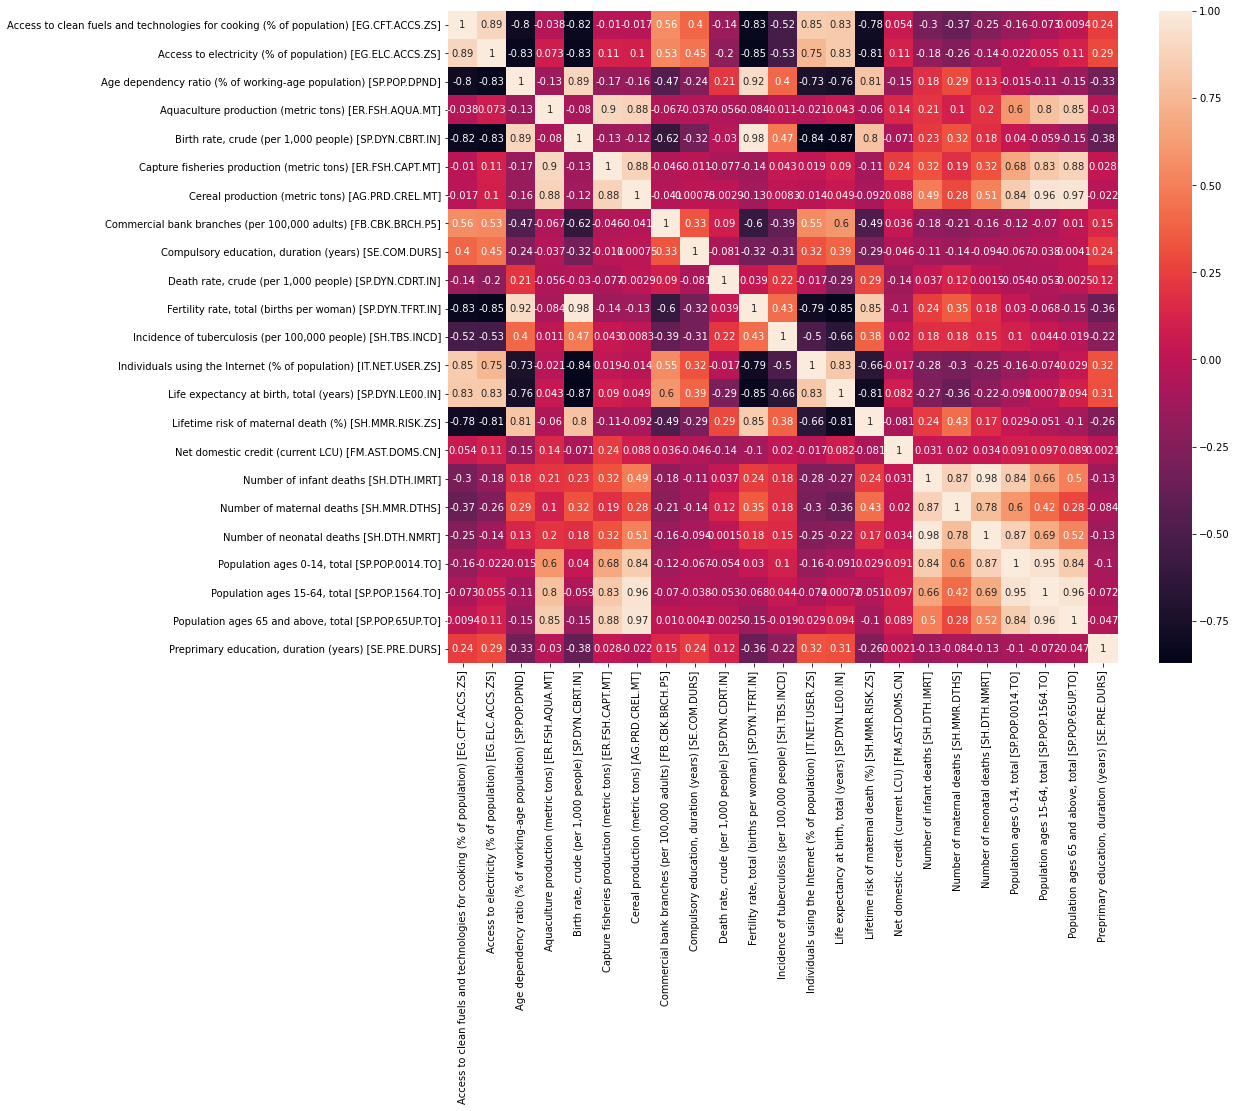

In [26]:
# Représentation graphique des correlations
plt.figure(figsize= (15, 12))
sns.heatmap(corr_df,annot=True)
plt.show()

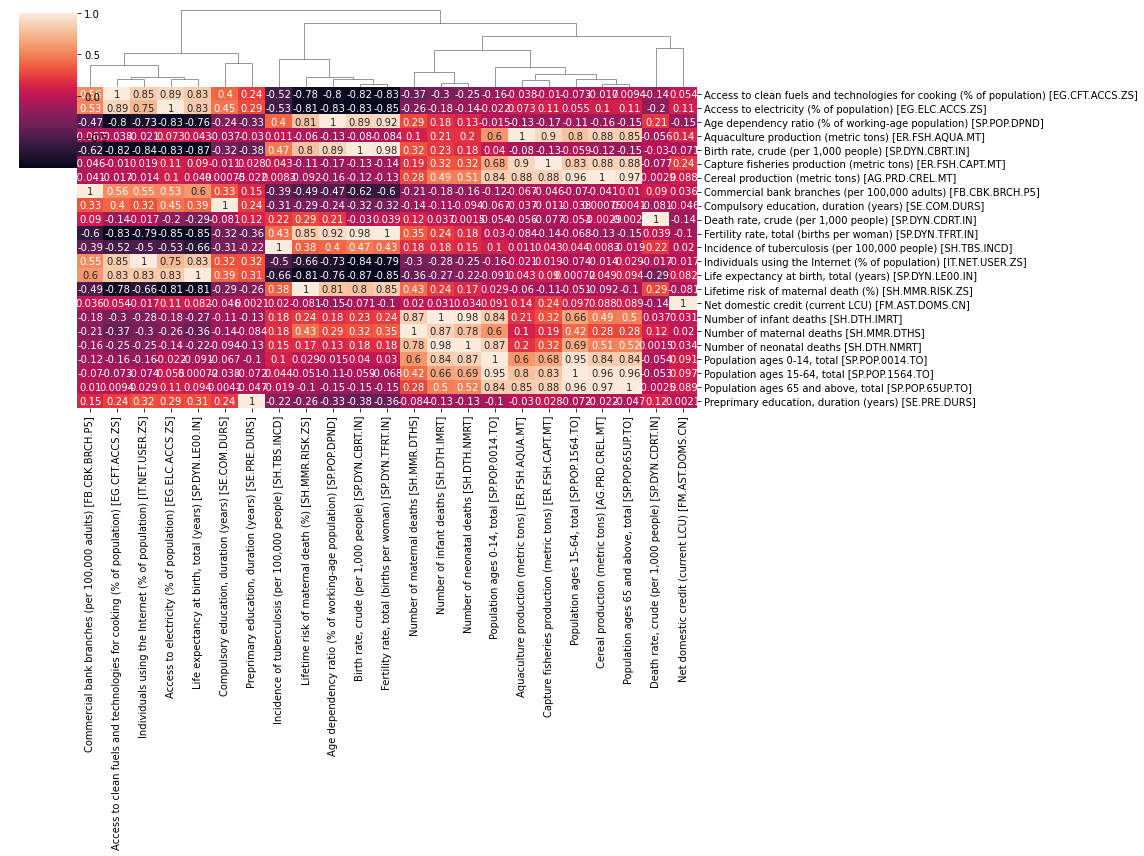

In [27]:
sns.clustermap(corr_df,
               figsize= (16, 12),
               annot=True,
               dendrogram_ratio=(0.1, 0.2),
               row_cluster=False)
plt.show()

In [28]:
def delete_corr(df, limit):
    #On construit notre matrice de correlation en valeur absolue
    corr_matrix = df.corr().abs()
    
    #Triangle supérieur de la matrice de corrélation : 
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > limit)]
    df = df.drop(df[to_drop], axis=1)
    return(df)

In [29]:
#Selection des attributs avec une limite de correlation = 55%
df = delete_corr(sparse_df3, 0.55)

In [30]:
df.shape

(133, 9)

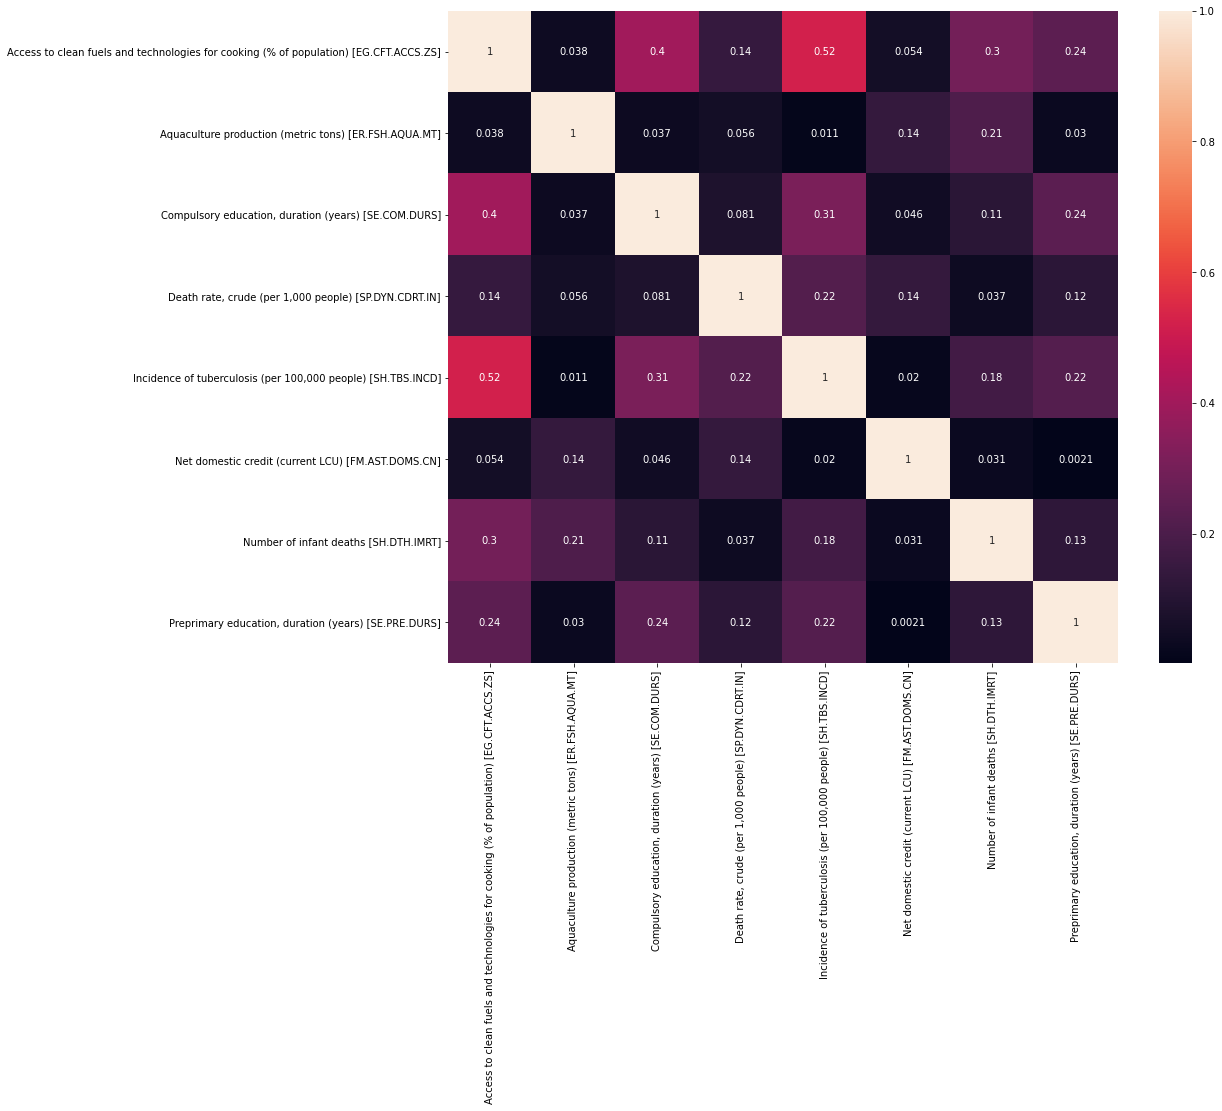

In [31]:
#Représentation graphique des correlations après selection
plt.figure(figsize= (15, 12))
sns.heatmap(df.corr().abs(), annot = True)
plt.show()

Comme il nous reste une dizaine d'attributs, nous avons décidé de retirer à la main la colonne "Crédit net domestique" dont on ne savait pas réellement à quoi elle correspondait et qu'il aurait fallu normaliser par la suite.

In [32]:
df = df.drop(columns=["Net domestic credit (current LCU) [FM.AST.DOMS.CN]"]) 

In [33]:
# On renomme les labels des colonnes pour plus de fluidite
df = df.rename(columns={"Access to clean fuels and technologies for cooking (% of population) [EG.CFT.ACCS.ZS]" : "Clean fuels and technologies for cooking acces (% pop)"})
df = df.rename(columns={"Aquaculture production (metric tons) [ER.FSH.AQUA.MT]" : "Aquaculture prod (metric tons)"})
df = df.rename(columns={"Compulsory education, duration (years) [SE.COM.DURS]" : "Compulsory education duration (years)"})
df = df.rename(columns={"Death rate, crude (per 1,000 people) [SP.DYN.CDRT.IN]" : "Death rate (per 10e3 )"})
df = df.rename(columns={"Incidence of tuberculosis (per 10e5 people) [SH.TBS.INCD]" : "Incidence of tuberculosis (per 100 000)"})
df = df.rename(columns={"Number of infant deaths [SH.DTH.IMRT]" : "Number of infant deaths"})
df = df.rename(columns={"Preprimary education, duration (years) [SE.PRE.DURS]" : "Preprimary education duration (years)"})

In [34]:
#Visualisation du jeu de donnees après toutes les sélections d'attributs et d'objets
df.head()

,Clean fuels and technologies for cooking acces (% pop),Aquaculture prod (metric tons),Compulsory education duration (years),Death rate (per 10e3 ),"Incidence of tuberculosis (per 100,000 people) [SH.TBS.INCD]",Number of infant deaths,Preprimary education duration (years),Continents
Country Name,,,,,,,,
Afghanistan,27.99,1100.000,9.0,7.141,189.0,64829.0,1.0,Asia
Albania,73.98,2424.200,9.0,7.219,16.0,314.0,5.0,Europe
Algeria,93.10,2410.973,10.0,4.709,72.0,21477.0,1.0,Africa
Angola,46.67,305.000,6.0,9.454,370.0,69089.0,1.0,Africa
Antigua and Barbuda,98.61,13.000,11.0,6.188,3.7,10.0,5.0,North America


A cette étape-ci, nous avons pu sélectionner tous les attributs et tous les objets de notre étude. Le jeu de données que nous allons analyser est donc composer de **133 pays et de 7 attributs différents** (la huitième colonne correspond aux continents, donc aux classes que nous avons rajouté nous-mêmes au début de l'étude): 

* Access to clean fuels and technologies for cooking (% of population) [EG.CFT.ACCS.ZS]
* Aquaculture production (metric tons) [ER.FSH.AQUA.MT]
* Compulsory education, duration (years) [SE.COM.DURS]
* Death rate, crude (per 1,000 people) [SP.DYN.CDRT.IN]
* Incidence of tuberculosis (per 10e5 people) [SH.TBS.INCD]
* Number of infant deaths [SH.DTH.IMRT]
* Preprimary education, duration (years) [SE.PRE.DURS]

## 3.4 Normalisation relative (aux surfaces et populations par pays) :

Le jeu de données obtenus contient deux attributs que l'on doit normaliser, puisqu'ils ne sont pas relatifs à la distribution du pays, alors que les autres le sont. Il s'agit de la **production d'aquaculture** que l'on va chercher à normaliser par rapport la surface du pays, et du **nombre de morts infantiles**, que l'on va normaliser par rapport à la taille de la population du pays. 

In [35]:
def remove_country(df, df_ref):
    tmp = df.copy(deep = True)
    for i, country in  enumerate( tmp["Country Name"]):
        if country not in df_ref.index.values:
            df = df.drop(tmp.index[i], axis = 0)
    return (df)

In [36]:
#On récupère les données de la taille de la population uniquement pour les 133 pays étudiés
population_size = pds.read_csv("./datas/Popula-schtroumpf/Population-size-per-country.txt", sep="\t", header=0)
population_size = remove_useless_col(population_size)
population_size = delete_NaN_row(population_size, 1)
population_size = remove_country(population_size, df)

In [37]:
#On récupère les données de la surface du territoire uniquement pour les 133 pays étudiés
surfaces = pds.read_csv("./datas/Surfa-schtroumpf/Country-surfaces.txt", sep="\t", header=0)
surfaces = remove_useless_col(surfaces)
surfaces = delete_NaN_row(surfaces, 1)
surfaces = remove_country(surfaces, df)

In [38]:
print (len(population_size) == len(df), len(surfaces)== len(df))

True True


In [39]:
df2 = df.copy(deep = True)
print("Avant la normalisation relative des données :", "\n")
df2.head()

Avant la normalisation relative des données : 



,Clean fuels and technologies for cooking acces (% pop),Aquaculture prod (metric tons),Compulsory education duration (years),Death rate (per 10e3 ),"Incidence of tuberculosis (per 100,000 people) [SH.TBS.INCD]",Number of infant deaths,Preprimary education duration (years),Continents
Country Name,,,,,,,,
Afghanistan,27.99,1100.000,9.0,7.141,189.0,64829.0,1.0,Asia
Albania,73.98,2424.200,9.0,7.219,16.0,314.0,5.0,Europe
Algeria,93.10,2410.973,10.0,4.709,72.0,21477.0,1.0,Africa
Angola,46.67,305.000,6.0,9.454,370.0,69089.0,1.0,Africa
Antigua and Barbuda,98.61,13.000,11.0,6.188,3.7,10.0,5.0,North America


In [40]:
df2.iloc[:, 1] =  df2.iloc[:, 1].values/surfaces.iloc[:, 1].values
df2 = df2.rename(columns={"Aquaculture prod (metric tons)" : "Aquaculture prod (metric tons/m²)"})
df2.iloc[:, 5] =  df2.iloc[:, 5].values/population_size.iloc[:, 1].values
df2 = df2.rename(columns={"Number of infant deaths" : "Rate of infant deaths in the population"})

print("Après la normalisation relative des données :", "\n")
df2.head()

Après la normalisation relative des données : 



,Clean fuels and technologies for cooking acces (% pop),Aquaculture prod (metric tons/m²),Compulsory education duration (years),Death rate (per 10e3 ),"Incidence of tuberculosis (per 100,000 people) [SH.TBS.INCD]",Rate of infant deaths in the population,Preprimary education duration (years),Continents
Country Name,,,,,,,,
Afghanistan,27.99,0.001685,9.0,7.141,189.0,0.001943,1.0,Asia
Albania,73.98,0.084320,9.0,7.219,16.0,0.000109,5.0,Europe
Algeria,93.10,0.001012,10.0,4.709,72.0,0.000552,1.0,Africa
Angola,46.67,0.000245,6.0,9.454,370.0,0.002564,1.0,Africa
Antigua and Barbuda,98.61,0.029545,11.0,6.188,3.7,0.000108,5.0,North America


## 3.5 Normalisation par centrage - réduction :

Enfin, pour terminer la partie de traitement de données, nous décidons de normaliser les données par centrage-réduction, selon la formule suivante : 

\begin{equation*}
    X = \frac{X - \mu}{\sigma}
\end{equation*}

En effet en visualisant les données sans cette normalisation, on voit que les ordres de grandeur, ainsi que les variances pour chaque attribut ne sont pas homogènes. On va donc centrer et réduire nos données pour corriger ce défaut.

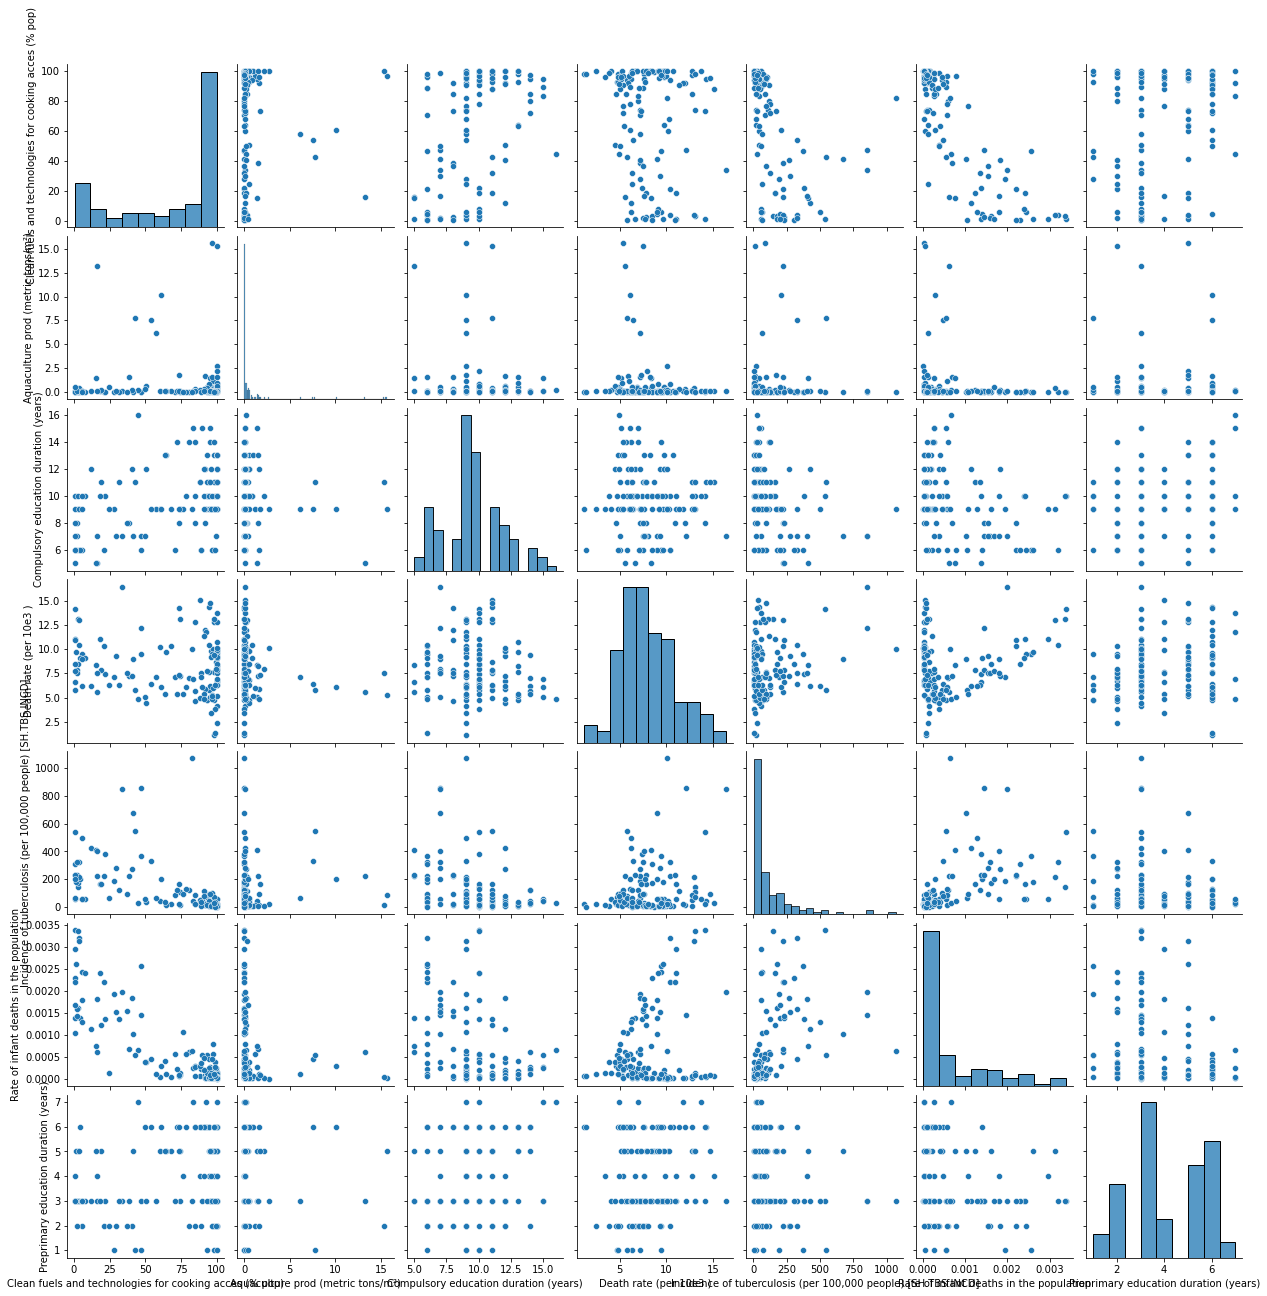

In [43]:
#Visualisation des donnees sans centrage-reduction
sns.pairplot(data=df2)
plt.show()

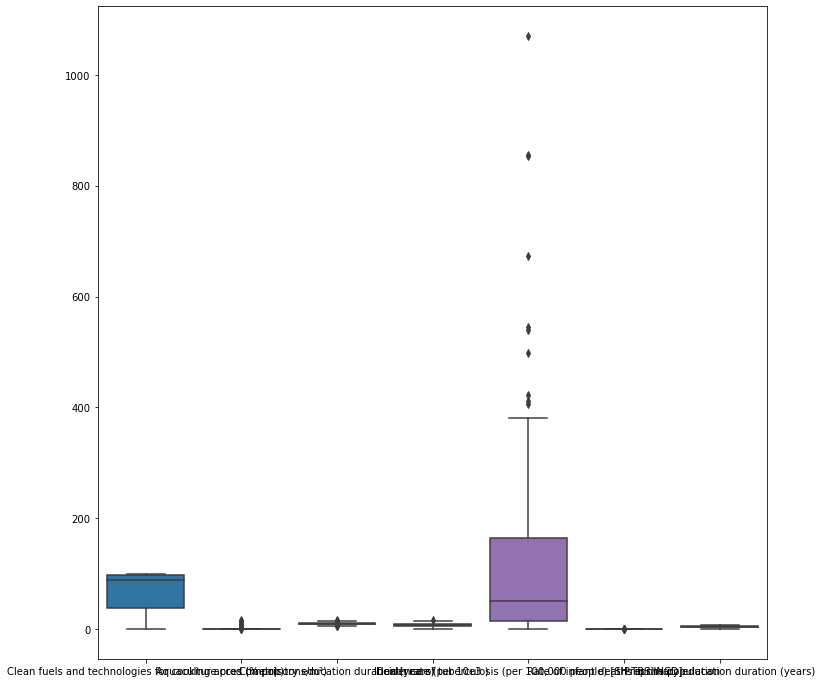

In [42]:
#Visualisation de boxplot des donnees sans centrage-reduction
plt.figure(figsize=(12,12))
sns.boxplot(data = df2)
plt.show()

#On voit que les ordres de grandeur de nos données ainsi que leur variances ne sont pas du tout homogènes.
#On va donc les normaliser (centrer - réduire) pour corriger ce défaut  

In [44]:
# Fonction qui centre et réduit une colonne de données pour les normaliser
def normalizer (data):
    # Quelques statistiques :
    mean = np.mean(data)
    var = np.var(data)
    sd = math.sqrt(var)
    
    norm = []
    for x in data:
        norm.append((x-mean)/sd)
    
    return (norm)

In [45]:
def norm_whole_df (df):
    normed_df = df.copy(deep = True)
    for i in df.columns:
        normed_df[i] = normalizer(df[i])
        
    return (normed_df)

In [46]:
normed_df = norm_whole_df(df2.drop(columns = "Continents" ))
normed_df["Continents"] = df2["Continents"]

In [47]:
normed_df.head()

,Clean fuels and technologies for cooking acces (% pop),Aquaculture prod (metric tons/m²),Compulsory education duration (years),Death rate (per 10e3 ),"Incidence of tuberculosis (per 100,000 people) [SH.TBS.INCD]",Rate of infant deaths in the population,Preprimary education duration (years),Continents
Country Name,,,,,,,,
Afghanistan,-1.108765,-0.312969,-0.266154,-0.329331,0.384291,1.493494,-1.849324,Asia
Albania,0.155076,-0.280558,-0.266154,-0.302294,-0.580856,-0.646360,0.616441,Europe
Algeria,0.680509,-0.313233,0.160334,-1.172330,-0.268439,-0.129380,-1.849324,Africa
Angola,-0.595424,-0.313534,-1.545618,0.472420,1.394068,2.218867,-1.849324,Africa
Antigua and Barbuda,0.831928,-0.302042,0.586822,-0.659667,-0.649476,-0.647116,0.616441,North America


In [48]:
normed_df.shape

(133, 8)

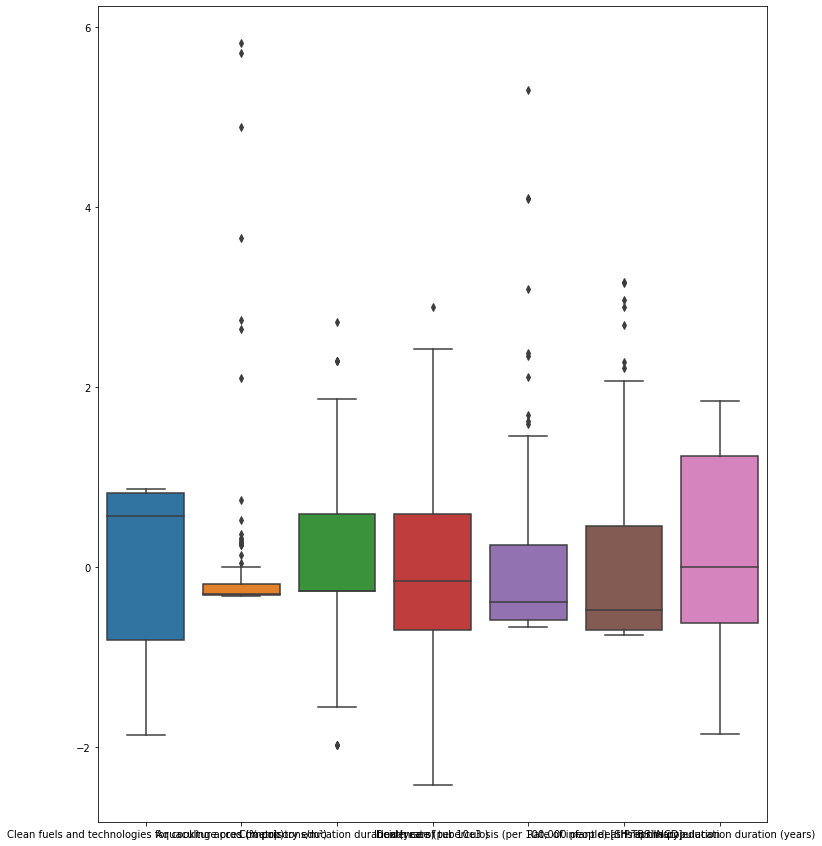

In [49]:
#Visualisation de boxplot des donnees après centrage-reduction
plt.figure(figsize=(12,15))
sns.boxplot(data = normed_df)
plt.show()

Le boxplot ainsi obtenu nous permet d'avoir une vue sur les possibles points "outliers" qui pourraient nous gêner pour l'analyse. On cherche donc à enlever les pays qui y sont associés.

In [55]:
from scipy import stats

In [56]:
def search_outliers_row(df, limit):
    z_scores = stats.zscore(df.drop(columns = "Continents" )) #calcule le z-score de df
    abs_z_scores = np.abs(z_scores) # on passe en valeurs absolues
    filtered_outliers = (abs_z_scores < limit).all(axis=1) # on ne garde que les lignes avec des valeurs > limit
    new_df = df[filtered_outliers] #nouveau df
    return (new_df)

In [57]:
df3 = search_outliers_row(normed_df, 3)

In [58]:
df3.shape

(123, 8)

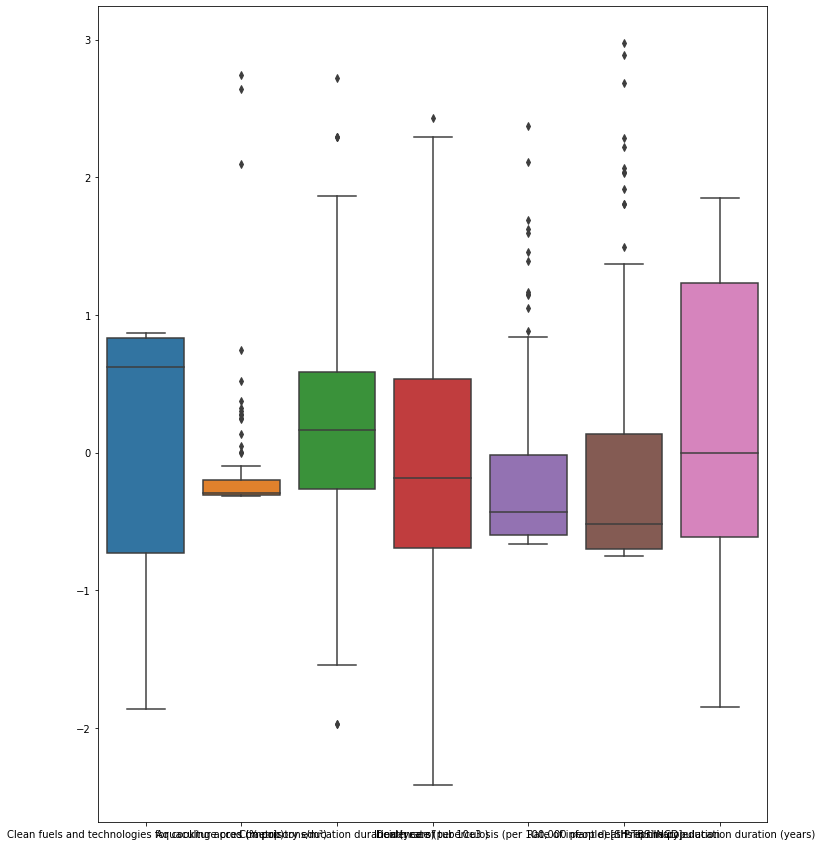

In [59]:
plt.figure(figsize=(12,15))
sns.boxplot(data = df3)
plt.show()

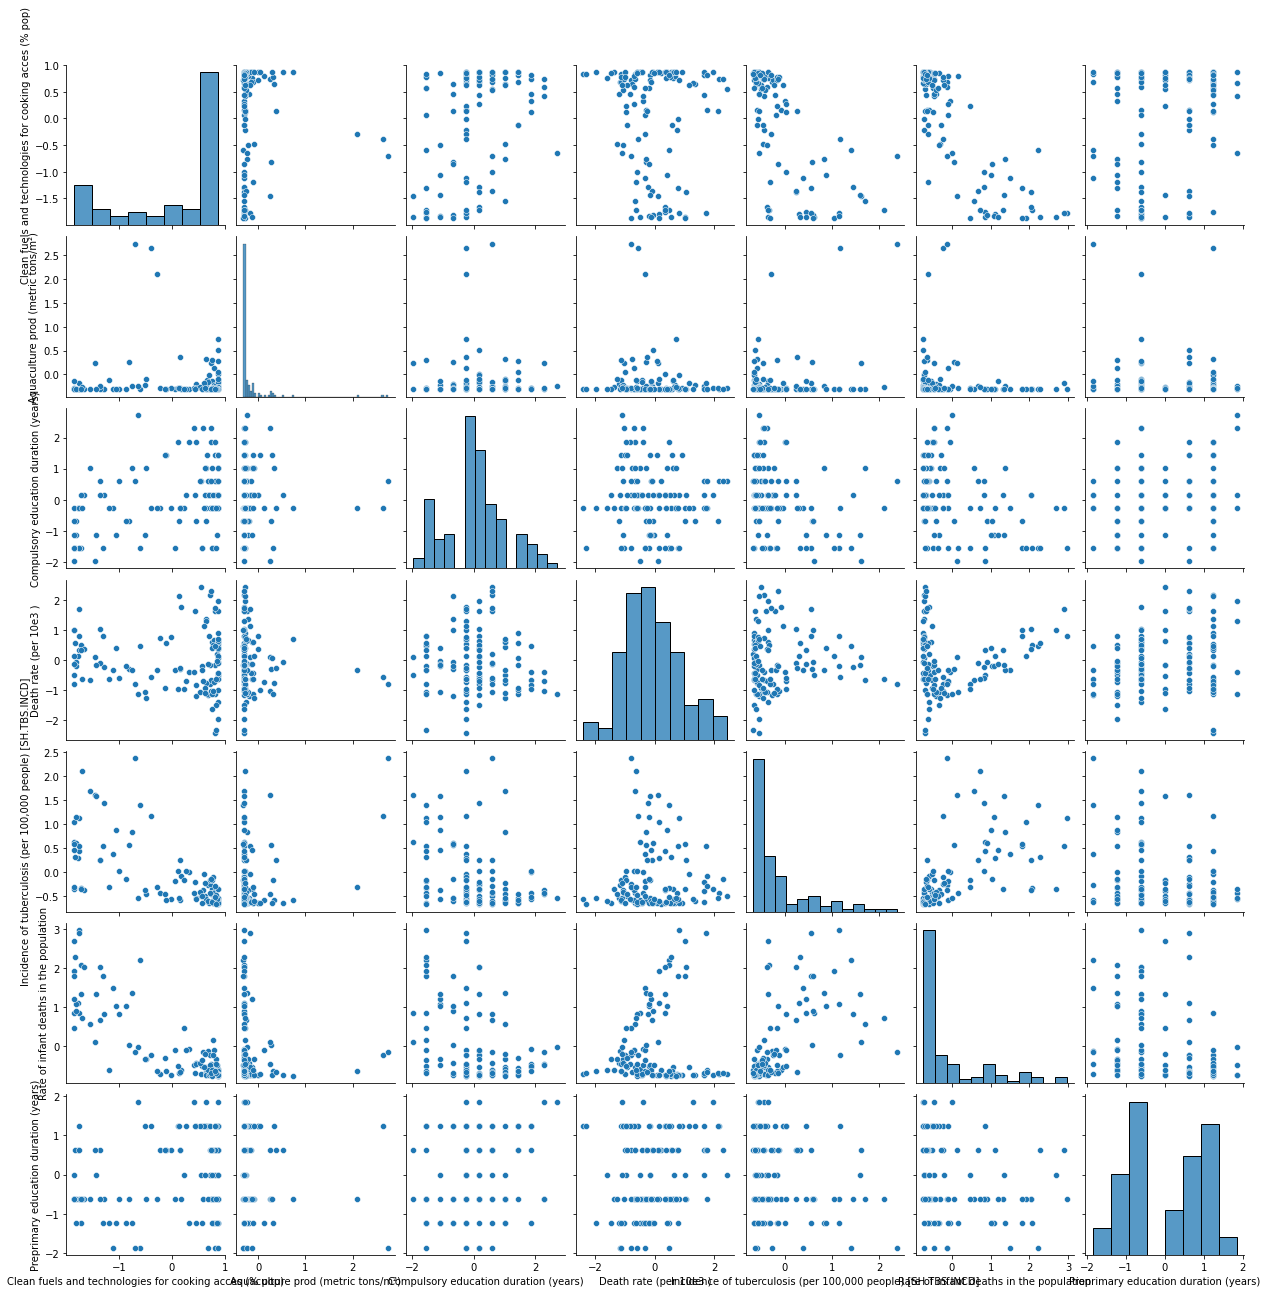

In [60]:
#Pairplot après standardisation
sns.pairplot(data=df3)
plt.show()

On refait ci-dessous des statistiques basiques sur notre nouveau jeu de données df3. On voit bien que notre moyenne est centrée sur 0 et que notre écart-type varie autour de 1 pour chaque attribut. La normalisation a donc fonctionné. De plus, on voit bien sur le boxplot qu'on a enlevé les outliers.

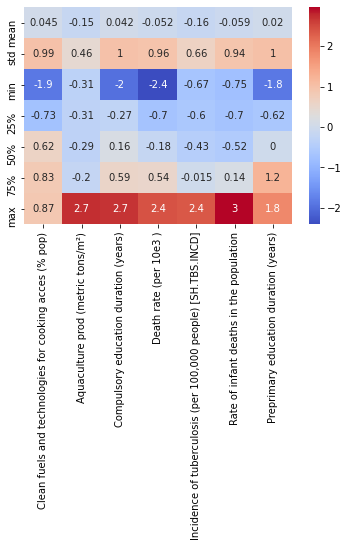

In [63]:
df_stats = df3.describe()
df_stats = df_stats.drop('count',axis=0)
sns.heatmap(df_stats,annot=True,cmap='coolwarm')
plt.show()

Finalement, le jeu de données que l'on va étudier contient **123 pays et 7 attributs**, présentés en section 3.3. 

# 4. Clustering :

## 4.1 K-means 

### 4.1.1 Création des clusters :

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [ ]:
df4 = df3.drop(columns = "Continents" )
classes = df3.Continents

Nous allons utilisé le jeu de données fraichement filtré et normalisé df2 :

In [ ]:
df4.head()

In [ ]:
# Création d'un object KMeans :
km = KMeans(n_clusters=4, init='k-means++',n_init=10, random_state=50, max_iter=300,)
km.fit(df4)

In [ ]:
km_clusters = km.labels_

In [ ]:
# On stocke les centroides obtenus :
centroids = km.cluster_centers_

In [ ]:
predict = km.predict(df4)

In [ ]:
print(predict)

In [ ]:
# Using matplotlib.pyplot instead of seaborn.scatterplot to display the clusters.
plt.scatter(df4["Clean fuels and technologies for cooking acces (% pop)"], df4["Compulsory education duration (years)"], c=km_clusters)
plt.title('Data in Space', fontsize=14)
plt.xlabel("Clean fuels and technologies for cooking acces (% pop)",fontsize=14)
plt.ylabel("Compulsory education duration (years)",fontsize=14 )
plt.scatter(centroids[:, 0], centroids[:, 2], c='red',s=150, alpha=0.4)
plt.grid(True)

### 4.1.2 Mesures sur nos kmeans :

In [ ]:
from collections import Counter 
Counter(predict)

#### a) SSE :

In [ ]:
SSE=km.inertia_
print(SSE)

In [ ]:
#Courbe de la SSE en fonction du nombre de clusters
SSE_liste=[]
for i in range(2,10):
    km2=KMeans(n_clusters=i, init='k-means++',  n_init=1, random_state=50, max_iter=1000).fit(df4)
    SSE_liste.append(km2.inertia_)
    
#print(SSE_liste)

SSE_liste_random=[]
x=[]
for i in range(2,10):
    km3=KMeans(n_clusters=i, init='random',  n_init=1, random_state=50, max_iter=1000).fit(df4)
    SSE_liste_random.append(km3.inertia_)
    x.append(i)
    
#print(SSE_liste_random)
plt.figure(figsize = (14, 10))
plt.plot(x, SSE_liste,label="k-means++")
plt.plot(x, SSE_liste_random,label="Random")
plt.xlabel("Nombre de clusters")
plt.ylabel("SSE")
plt.legend()
plt.show()

Table de contingence avec les différents clusters vs les classes (ici continents) :

In [ ]:
km_crosstab = pds.crosstab(km_clusters,classes)
sns.heatmap(km_crosstab, annot=True)
plt.show()

#### b) Mesures d'entropie

Entropie des clusters (c) comparés aux différentes classes (j):

$-\sum{p(j|c) \times log(p(j|c)}$

$p(j|c)$ est la fréquence d'apparition de la classe j dans le cluster c.

In [ ]:
proba = km_crosstab.values/km_crosstab.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
entropy = [stats.entropy(row, base=2) for row in proba]
print("entropy of each cluster: ", entropy)

#### c) Mesure de pureté :

Pour calculer la pureté, chaque cluster est attribué à la classe qui est la plus fréquente dans ce cluster, puis la précision de cette attribution est mesurée en comptant le nombre d'éléments correctement attribués. Il s'agit donc de mesurer la précision d'un cluster à ne contenir les objets que d'une seule classe.

En réalité il s'agit d'une terminologie dérivant de l'entropie.

$purete = \sum_{j=1}^{K} \frac{m_c}{m} \times purete(c)$

- $purete(c) = max(p(j,c))$;
- $p(j,c)$ est la probabilité qu'un membre du cluster $c$ appartienne à la classe $j$;
- $m_c$ est la taille du cluster $c$;
- $m$ est la taille totale du nombre d'éléments (points).

In [ ]:
def purity_score(classes, predictions):
    contingency_matrix = metrics.cluster.contingency_matrix(classes, predictions)
    return ( np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) )

In [ ]:
purity_score(classes, km_clusters)

<ins>Remarque :</ins> Une grande pureté est facile à atteindre lorsque le nombre de clusters formés devient important. En particulier, la pureté tend vers $1$ si le nombre de cluster tend à être égale aux nombre de points. Ainsi, nous ne pouvons pas utiliser la pureté pour faire un compromis entre la qualité du regroupement et le nombre de regroupements.

Une mesure qui nous permet de faire ce compromis est l'information mutuelle normalisée ou INM : 

#### d) Information mutuelle normalisée (IMN) :

$IMN(j,c) = \frac{2 \times I(j, c)}{E(j) + E(c)}$

- $j$ = label de la classe ;
- $c$ = label du cluster ;
- $E()$ = entropie ;
- $I(j, c)$ = information mutuelle entre j et c. $I(j, c) = E(j) - E(j|c)$, où $E(j|c)$ désigne une entropie conditionnelle.

In [ ]:
metrics.normalized_mutual_info_score(classes, km_clusters, average_method='max')

#### d) Coefficient de silhouette :

Le coefficient de silhouette pour un  point correspond à la différence entre sa distance moyenne avec les points du même cluster que lui (**cohésion**) et la distance moyenne avec les points des autres clusters voisins (**séparation**). Il est compris en $-1$ et $1$.

 - Si on a une différence négative, le point est en moyenne plus proche du groupe voisin que du sien ;
 - Si on a une différence positive, le point est en moyenne plus proche de son groupe que du groupe voisin.

In [ ]:
Silh = metrics.silhouette_score(df4.values, 
                         km_clusters, 
                         metric='euclidean', 
                         sample_size=None) 
print("Coefficient de silhouette pour nos 3 clusters : ",Silh)

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

Avec le code suivant nous pouvons observer les silhouettes de chaque cluster, pour un nombre total de  2, 3, 4, 5, 6 et 7 clusters

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15,10))
for i in [2, 3, 4, 5, 6, 7]:
    
    km_simu = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2) # permet d'attribuer les axes pour les subplots 
    
    visualizer = SilhouetteVisualizer(km_simu, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df4)

### 4.1.3 Stabilité de la convergence de nos k-means :

La convergence d'un algorithme K-Means peut être vue comme étant la stabilisation des centroids des clusters (les centroids ne bougent plus lors des itérations).

#### a) Calcul de la stabilité pour la convergence de notre K-means :

In [ ]:
avg_silhouette_coef = []
sse_list = []
k = 6
for i in range(600):
    km = KMeans(n_clusters=k, init='random', n_init=1)
    km.fit(df4)
    labels = km.predict(df4)
    sse_list.append(np.sqrt(km.inertia_))
    avg_silhouette_coef.append(metrics.silhouette_score(df4, labels,metric='euclidean'))

In [ ]:
plt.figure(figsize=(18, 10))

plt.subplot(2,2,1)
plt.hist(sse_list, edgecolor = "black")
plt.title("SSE", fontsize = 18)

plt.subplot(2,2,2)
plt.hist(avg_silhouette_coef, edgecolor = "black")
plt.title("Average silhouette coeff", fontsize = 18)

plt.subplot(2,2,3)
plt.boxplot(sse_list)

plt.subplot(2,2,4)
plt.boxplot(avg_silhouette_coef)

plt.show()

#### b) Même chose mais avec un nombre d'executions interne plus grand :

Ici nous allons effectuer la même opération qu'au dessus en changeant la valeur du *n_init* par une valeur plus élevée. Pour rappel le paramètre *n_init* représente le nombre de fois où l'algorithme du k-means sera exécuté avec différentes graines pour les centroïdes. Le meilleur résltat en terme d'inertie sera retenue parmi tous les *n_init*.

In [ ]:
avg_silhouette_coef = []
sse_list = []
k = 6
for i in range(600):
    km = KMeans(n_clusters=k, init='random', n_init = 30)
    km.fit(df4)
    labels = km.predict(df4)
    sse_list.append(np.sqrt(km.inertia_))
    avg_silhouette_coef.append(metrics.silhouette_score(df4, labels,metric='euclidean'))

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.hist(sse_list, color='coral', edgecolor = "black")
plt.title("SSE", fontsize = 18)

plt.subplot(1,2,2)
plt.hist(avg_silhouette_coef, color = 'coral', edgecolor = "black")
plt.title("Average silhouette coeff", fontsize = 18)


plt.show()

#### c) Evaluation de la stabilité de convergence un nombre de clusters différents :

In [ ]:
def compute_stability(km,df,iterations=100):
    avg_silhouette_coef = []
    sse_list = []
    for i in range(500):
        km.fit(df)
        labels = km.predict(df)
        avg_silhouette_coef.append(metrics.silhouette_score(df, labels,metric='euclidean'))
    avg_silhouette_coef = np.asarray(avg_silhouette_coef)
    return(avg_silhouette_coef.std())

In [ ]:
stability = []
Ks = range(2,12)
for k in Ks:
    km = KMeans(n_clusters=k,init='random',n_init=5)
    stability.append(compute_stability(km,df4))

In [ ]:
plt.plot(Ks,stability,"o-")
plt.xlabel("number of clusters ",fontsize=20)
plt.ylabel("Avg. Silhouette Coef")

In [ ]:
print("Le nombre de clusters pour une stabilité optimale est : ", int(stability.index(max(stability))) + 2)

## 4.2 Hierachical clustering :

### 4.2.1 Méthode : "complete"

In [ ]:
z_complete = sch.linkage(df4, method = 'complete', metric='euclidean')

In [ ]:
z_complete.shape

In [ ]:
plt.figure(figsize=(20, 40))
dendro = sch.dendrogram(z_complete, 
                        orientation='right', 
                        leaf_rotation=0, 
                        leaf_font_size=14,
                        labels = df4.index)
plt.title("Dendrogram with complete methode")
plt.ylabel("Countries")
plt.xlabel("Distance")
plt.grid(False)
plt.show()

### 4.2.2 Méthode : "single"

In [ ]:
z_single = sch.linkage(df4, method = 'single', metric='euclidean')

In [ ]:
z_single.shape

In [ ]:
plt.figure(figsize=(20, 40))
dendro = sch.dendrogram(z_single, 
                        orientation='right', 
                        leaf_rotation=0, 
                        leaf_font_size=14,
                        labels = df4.index)
plt.title("Dendrogram with single methode")
plt.ylabel("Countries")
plt.xlabel("Distance")
plt.grid(False)
plt.show()

In [ ]:
# 2nd derivative of the distances

acceleration_complete = np.diff(z_complete[:,2], 2)
acceleration_single = np.diff(z_single[:,2], 2) 

In [ ]:
plt.figure(figsize=(32, 18))

plt.subplot(131)
plt.plot(z_single[:, 2], 'o-', color = "blue")
plt.plot(z_complete[:, 2], 'o-', color = "orange")
plt.legend(["single","complete"])
plt.ylabel("Hauteur", fontsize = 22)
plt.xlabel("Pays par ordre croissant", fontsize = 22)
plt.grid(axis='y')

plt.subplot(132)
plt.plot(z_complete[:, 2], 'o-', color = "orange")
plt.plot(acceleration_complete, 'o-', color='green')
plt.ylabel("Hauteur", fontsize = 22)
plt.legend(["complete","dérivée seconde de complete"], fontsize = 22)
plt.xlabel("Pays par ordre croissant", fontsize = 22)

plt.subplot(133)
plt.plot(z_single[:, 2], 'o-', color = "blue")
plt.plot(acceleration_complete, 'o-', color='green')
plt.legend(["single","dérivée seconde de signle"], fontsize = 22)
plt.ylabel("Hauteur", fontsize = 22)
plt.xlabel("Pays par ordre croissant", fontsize = 22)

## 4.3 DB scan :

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

Une méthode pour estimer le meilleur paramètre **eps** pour notre DBscan serait de calculer la distance de chaque point par rapport à son voisin le plus proche en utilisant les **NearestNeighbors**. Le point lui-même est inclus dans n_neighbors. Nous obtenons ensuite deux tableaux:

- Un qui contient la distance aux points n_neighbors les plus proches ;
- Le deuxième contient l'indice pour chacun de ces points.

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df4.values)
distances, indices = nbrs.kneighbors(df4.values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

Nous pouvons ordonner nos résultats et les afficher dans un plot semblable à ceux déja vu pour des les SSE. 

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
eps_curve = ax.plot(distances, 'o-', color='b')
plt.ylabel("eps", fontsize = 18)
plt.show() 

Enfin la valeur optimale pour le paramètre **eps** trouve à la courbure maximale de la courbe, lu en ordonnée.

Pour le déterminer nous allons importer la librairie Kneed qui va utiliser la méthode "des genoux".

In [ ]:
from kneed import KneeLocator
points = eps_curve[0].get_data() # on récupère les points de la courbe (x et y)

kneedle = KneeLocator(points[0], points[1], S=1.0, curve="convex", direction="increasing")
knee = int( kneedle.knee )
print("Meilleur paramètre epsilon  : ", round(points[1][knee], 3) )

In [ ]:
dbscan = DBSCAN(eps = 1.478, min_samples=4)
dbscan.fit(df4)

In [ ]:
db_clusters = dbscan.labels_

In [ ]:
print(db_clusters)

In [ ]:
# Contingency table of species vs cluster labels
crosstab = pds.crosstab(db_clusters,classes)
sns.heatmap(crosstab, annot=True)

In [ ]:
# Cluster views in 2D projections

db_results = df4.copy()
db_results['cluster']= db_clusters
classes_map = classes.map({'Africa':0, 'Asia':1, 'Europe':2, 'North America': 3, 'South America':4})
db_results['class']= classes_map.values

In [ ]:
db_results.head()

In [ ]:
sns.pairplot(data=db_results,hue='cluster')
plt.show()

## 4.4 Decision tree :



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz

In [ ]:
df_train, df_test, classes_train, classes_test = sklearn.model_selection.train_test_split(df4, df3.Continents,
                                                             test_size=1/3, 
                                                             train_size=2/3,
                                                             random_state=None, 
                                                             shuffle=True, 
                                                             stratify=None)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(df_train, classes_train)

In [ ]:
classes_predicted = clf.predict(df_test)

In [ ]:
pds.crosstab(classes_test, classes_predicted)

In [ ]:
# Autre façon d'avoir la même table :

from sklearn.metrics import confusion_matrix
confusion_matrix(classes_test, classes_predicted)

In [ ]:
accuracy_score (classes_test, classes_predicted)

In [ ]:
plt.figure(figsize=(18,10))
tree.plot_tree(clf,filled=True,class_names=clf.classes_)
plt.show()

In [ ]:
# Autre visualisation plus sympa utilisant graphviz  (décommenter pour visualier):

tree_plot = tree.export_graphviz(clf, out_file = None, 
                           feature_names = df_train.columns,
                           class_names = clf.classes_, 
                           filled=True, rounded = True,
                           special_characters = True)

graph = graphviz.Source(tree_plot)
#display ( graph ) 

## 4.5 Validation croisée :

In [ ]:
from sklearn.model_selection import StratifiedKFold #cross-validation splitter
from sklearn.model_selection import cross_validate #cross-validation evaluation of metrics

In [ ]:
tests = ['accuracy', 
         'precision_macro', 
         'precision_weighted', 
         'recall_macro', 
         'recall_weighted', 
         'f1_macro', 
         'f1_weighted']

cv = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
cv_scores = cross_validate(clf, df4, classes, scoring = tests, cv = cv, return_train_score = False)

In [ ]:
pds.DataFrame(cv_scores).mean()